# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [56]:
# Load pickled data
import pickle

training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [57]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len( set(y_train) )

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

9


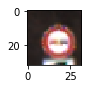

In [61]:
import matplotlib
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import numpy as np

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

print(y_train[index])

plt.figure(figsize=(1,1))
plt.imshow(image)

Let's plot a few random images to get a sense for the  dataset

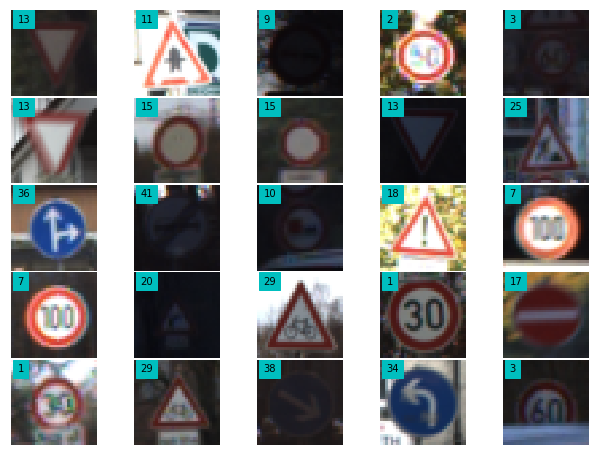

In [5]:
def plot_random_grid(n_row,n_col,X,y):
    plt.figure(figsize = (11,8))
    gs1 = matplotlib.gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

plot_random_grid(5,5,X_train,y_train)

As we can see some images are quite dark, while some are overexposed. We could think about normalising their brightness during preprocessing

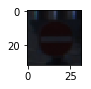

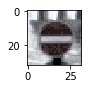

In [6]:
import cv2  

index = 31078 #random.randint(0, len(X_train))
image = np.copy( X_train[index].squeeze() )
image1 = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image1[:,:,0] = cv2.equalizeHist(image1[:,:,0])
image1 = cv2.cvtColor(image1, cv2.COLOR_YUV2RGB)


plt.figure(figsize=(1,1))
plt.imshow(image)
plt.show()

plt.figure(figsize=(1,1))
plt.imshow(image1)
plt.show()

This definitely increases contrast and thus helps ( thinking as a human, who knows what the NN prefers... ) but it could lead to some artifacts as well, so we'll test its efficacy and not apply it blindly.

Finally let's have a look at the class distribution:

In [7]:
import pandas as pd

class_freq = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]

sign_names = pd.read_csv('signnames.csv')
sign_names['freq'] = pd.Series(np.asarray(class_freq).T[1], index=np.asarray(class_freq).T[0])
class_freq_sorted = sign_names.sort_values(['freq'],ascending=[0]).reset_index()
class_freq_sorted = class_freq_sorted.drop('index', 1)

In [8]:
## Visualise the top 10 classes (wrt to frequence)
class_freq_sorted.head(10)

ClassId                                      SignName  freq
0        2                          Speed limit (50km/h)  2010
1        1                          Speed limit (30km/h)  1980
2       13                                         Yield  1920
3       12                                 Priority road  1890
4       38                                    Keep right  1860
5       10  No passing for vehicles over 3.5 metric tons  1800
6        4                          Speed limit (70km/h)  1770
7        5                          Speed limit (80km/h)  1650
8       25                                     Road work  1350
9        9                                    No passing  1320

In [9]:
# and the bottom 10
class_freq_sorted.tail(10)

ClassId                                           SignName  freq
33       21                                       Double curve   270
34       29                                  Bicycles crossing   240
35       24                          Road narrows on the right   240
36       41                                  End of no passing   210
37       42  End of no passing by vehicles over 3.5 metric ...   210
38       32                End of all speed and passing limits   210
39       27                                        Pedestrians   210
40       37                                Go straight or left   180
41       19                        Dangerous curve to the left   180
42        0                               Speed limit (20km/h)   180

As we can see, there's a lot of discrepancy, with the least represented classes (20 km/h speed limit, dangerous curves, ... ) having as far as 10 times less instances than the most represented ones ( 50 or 30 km/h speed limit , ... )
Let's see an histogram!


<Container object of 43 artists>

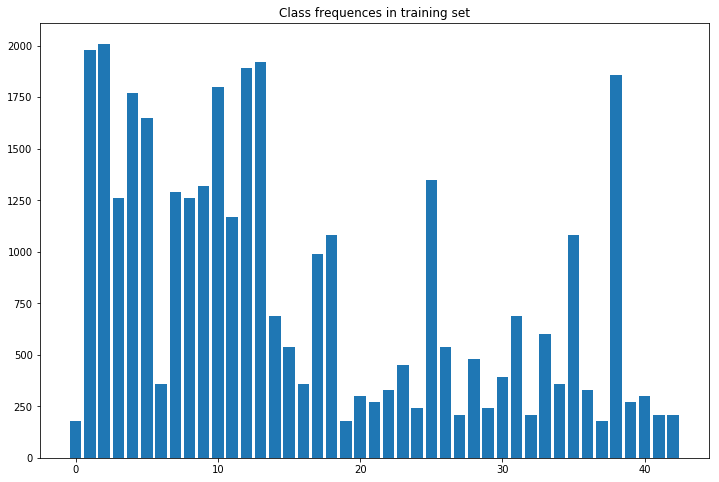

In [10]:
plt.figure(figsize=(12,8))
plt.title('Class frequences in training set')
plt.bar(range(n_classes),height=sign_names['freq'])

<Container object of 43 artists>

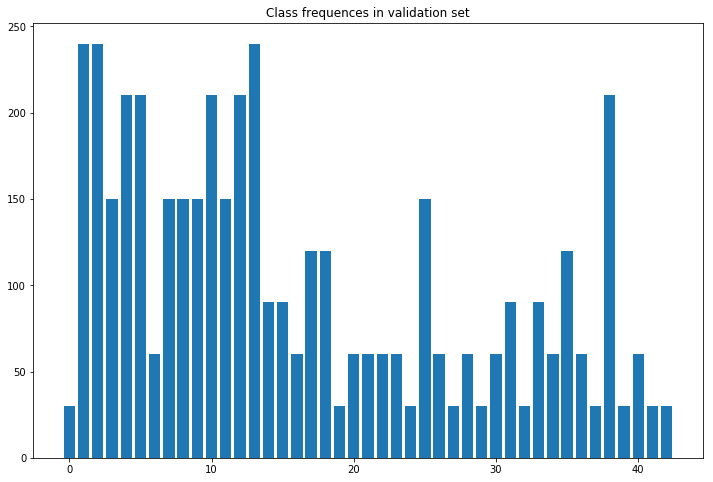

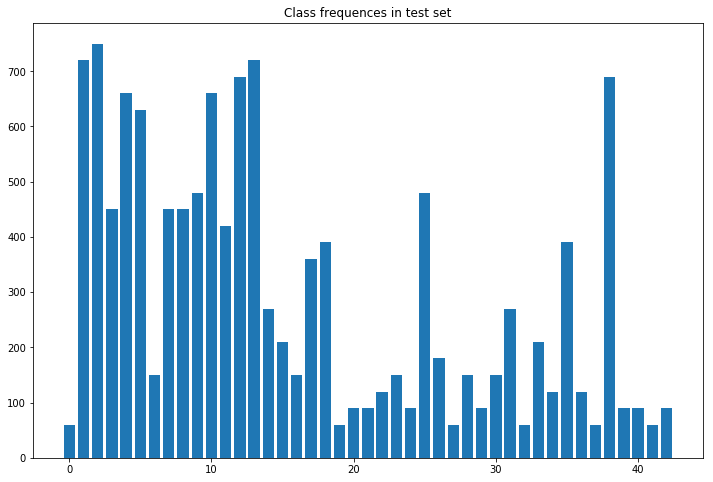

In [11]:
class_freq = [[i,sum(y_valid == i)] for i in np.unique(y_valid)]
sign_names['freq_valid'] = pd.Series(np.asarray(class_freq).T[1], index=np.asarray(class_freq).T[0])

plt.figure(figsize=(12,8))
plt.title('Class frequences in validation set')
plt.bar(range(n_classes),height=sign_names['freq_valid'])

class_freq = [[i,sum(y_test == i)] for i in np.unique(y_test)]
sign_names['freq_test'] = pd.Series(np.asarray(class_freq).T[1], index=np.asarray(class_freq).T[0])

plt.figure(figsize=(12,8))
plt.title('Class frequences in test set')
plt.bar(range(n_classes),height=sign_names['freq_test'])

As we can see, similar patterns of frequencies can be observed in both the validation and test sets.

### Correcting this class bias

We will definitely oversample the data by transforming the existing images and applying random transformations to them before feeding the data to the NN. We might want to correct this bias toward the more frequent signs by sampling more images for the least represented classes and less for the already frequent one.

This bias though is probably not random, but symbolise a real difference in frequency of signals on the street overall; so we don't want to correct it all the way to equalise all the class frequencies. Moreover, because there's such a wide difference, obtaining a uniform frequency of say twice as many as the most represented classes would lead to resample on average more than 20 times each single image in the least represented classes, leading probably the NN to almost interpolate those image and probably performing badly on new images of that class.

## Data Augmentation

We will sample extra data by randomly translating, rotating ( in a certain range, we don't want to end up flipping a left/right sign ) and shifting ( to simulate change in perspective ) the base image. We'll also apply a brightness change, in case we don't end up normalising the brightness during preprocessing.

In [12]:
import math 

def transform_image(img, max_angle=15, scale=0.1, trans_max=3, dist_max=3, bright_max=0.7):

    image = np.copy( img )
    
    width, height, channels = image.shape
    center = np.array([width / 2., height / 2.])
    
    random_angle = np.random.uniform(low=-1, high=1) * max_angle/180. * math.pi
    random_scale = scale * np.random.uniform(low=-1, high=1) + 1 
    cos_angle = random_scale*math.cos(random_angle)
    sin_angle = random_scale*math.sin(random_angle)
    
    random_rotation = np.array([[cos_angle, sin_angle],[-sin_angle,cos_angle]])
    random_translation = trans_max * np.random.uniform(low=-1, high=1, size=(1,2))
    random_distortortion = dist_max * np.random.standard_normal(size=(4,2))
        
    src = np.array([[0., 0.], [0., height], [width, height], [width, 0.]])
    dst = np.matmul(src-center, random_rotation) + center  + random_translation

    #add perspective tranformation
    dst = dst + random_distortortion

    M  = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32)) 
    image = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR,
                                  borderMode=cv2.BORDER_REFLECT_101)  # border reflect avoids the black space around the transformed image
    image = image.astype(np.float32)

    #add random brightness
    alpha = 1.0 + bright_max*random.uniform(-1, 1)
    image *= alpha
    image = np.clip(image,0.,255.) ## restrict to correct range
    
    image = image.astype(np.uint8)
    
    return image


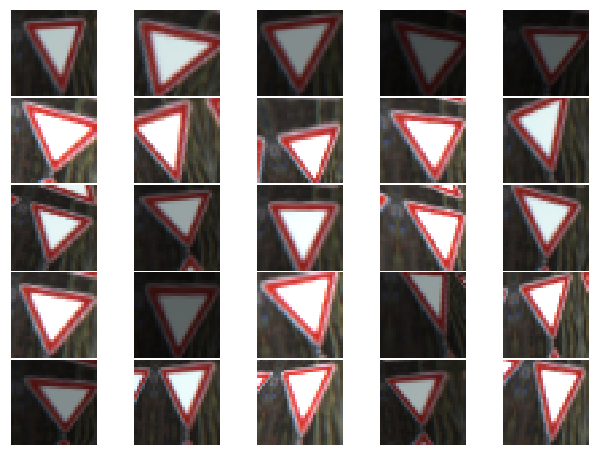

In [13]:
index = random.randint(0, len(X_train))
image = np.copy( X_train[index].squeeze() )

X_extra = [ transform_image(image) for i in range(25) ]

plt.figure(figsize = (11,8))
gs1 = matplotlib.gridspec.GridSpec(5,5)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

for i in range(5*5):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ind_plot = i
    plt.imshow(X_extra[ind_plot])
    plt.axis('off')
plt.show()

The number of oversampled images will depend on its class frequency (inversely proportional)

In [14]:
def gen_extra_data(X,y,max_images_per_class):

    X_aug = []
    y_aug = []
    n = len(X)

    classes = np.unique(y)

    class_idx = [ np.asarray(y==c).nonzero()[0] for c in classes ]
    
    n_img_per_class = np.array([ len(x) for x in class_idx ])
    
    final_n_per_class = (1.5*max_images_per_class + n_img_per_class) / 2.5
    extra_n_per_class = np.maximum( 0 , final_n_per_class - n_img_per_class )
    extra_n_per_class = extra_n_per_class.astype(int)

    for i in range(len(classes)):
        c = classes[i]

        for o in range(n_img_per_class[i]): # original
            X_aug.append( X[ class_idx[i][o] ] )
            y_aug.append( c )

        if extra_n_per_class[i] > 0:
            idx = np.random.choice(class_idx[i], extra_n_per_class[i], replace=True)
            for e in range(extra_n_per_class[i]): # extra
                
                img_trf = transform_image(X[ idx[e] ])
                X_aug.append(img_trf)
                y_aug.append(c)   

    return X_aug,y_aug

In [15]:
# Extend the training data with transformed images
X_train , y_train = gen_extra_data(X_train,y_train,4000)

print(len(X_train))

117119


<Container object of 43 artists>

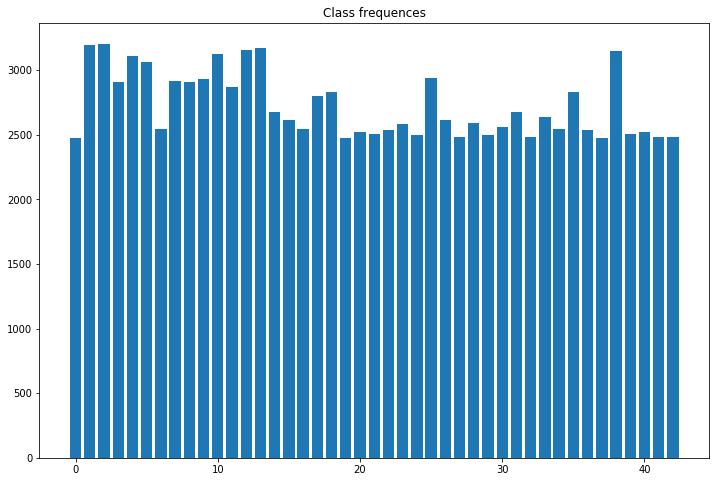

In [16]:
class_freq = [[i,sum(y_train == i)] for i in np.unique(y_train)]
sign_names['freq_new'] = pd.Series(np.asarray(class_freq).T[1], index=np.asarray(class_freq).T[0])

plt.figure(figsize=(12,8))
plt.title('Class frequences')
plt.bar(range(n_classes),height=sign_names['freq_new'])

As we can see the new histogram is much more balanced than the initial one. Again we decided to preserve some of the bias toward the more represented classes as this might reflect a real difference in frequencies of signals on the road.
**[ Is this reasoning any good? ]**

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set (normalization, grayscale, etc.)

We'll standardise the images ( in all sets ) using the below function. It first convert the image to the YUV color space, as adviced by [the paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), then use histogram equalisation to standardise the brightness in the image and finally normalise all layers to the [0,1] range.

Note we do not convert to grayscale, but we'll use mostly the brightness channel (see architecture below)

In [17]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def img_preprocess( img ):
    """
    Various normalisation and transformations to be applied 
    to the source images before feeding into the NN
    """
    image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Convert to YUV, as suggested by http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
    image[:,:,0] = cv2.equalizeHist(image[:,:,0]) # equalize histogram of the brightness channel

    image.astype(np.float32) # convert to float and normalise the pixel values
    image = (image-128.)/128.
        
    return image

In [18]:
X_train = [ img_preprocess(x) for x in X_train ]
X_valid = [ img_preprocess(x) for x in X_valid ]
X_test = [ img_preprocess(x) for x in X_test ]

### Model Architecture

Starting from the LeNet-5 architecture used in the Tensorflow introduction, I added a few convolutional layers to improve performances, added dropout to a couple key layers and added a regularisation calculation. More details in the project writeup.

Note that I do not use the grayscalechannel only, but at the first layer I use 20 convolutional filters on the brightness channel alone and only 4 on the UV channels that contain the color information. This is because after reading [the paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) I expect the Y channel to contain most of the information, but still completely disregarding color could hinder the recognition of a few images in the set.

In [19]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

## convolutional layer with added bias and relu units
def conv2d(x, W, b, strides=1,pad='VALID'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=pad)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

## maxpooling with filter-size = stride
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

keep_prob = tf.placeholder(tf.float32)

In [20]:
def MeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu, sigma = 0, 0.1
    
    # classes for the Traffic Signs dataset
    n_classes = 43

    # Store layers weight & bias
    weights = {
        'wc1_y': tf.Variable(tf.truncated_normal([3, 3, 1, 20],mean=mu,stddev=sigma)),
        'wc1_uv': tf.Variable(tf.truncated_normal([3, 3, 2, 4],mean=mu,stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([3, 3, 24, 32],mean=mu,stddev=sigma)),
        'wc3': tf.Variable(tf.truncated_normal([3, 3, 32, 64],mean=mu,stddev=sigma)),
        'wc4': tf.Variable(tf.truncated_normal([3, 3, 64, 128],mean=mu,stddev=sigma)),
        'wf1': tf.Variable(tf.truncated_normal([5*5*128, 1024],mean=mu,stddev=sigma)),
        'wf2': tf.Variable(tf.truncated_normal([1024, 600],mean=mu,stddev=sigma)),
        'wout': tf.Variable(tf.truncated_normal([600, n_classes],mean=mu,stddev=sigma))}

    biases = {
        'bc1_y': tf.Variable(tf.truncated_normal([20],mean=mu,stddev=sigma)),
        'bc1_uv': tf.Variable(tf.truncated_normal([4],mean=mu,stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([32],mean=mu,stddev=sigma)),
        'bc3': tf.Variable(tf.truncated_normal([64],mean=mu,stddev=sigma)),
        'bc4': tf.Variable(tf.truncated_normal([128],mean=mu,stddev=sigma)),
        'bf1': tf.Variable(tf.truncated_normal([1024],mean=mu,stddev=sigma)),
        'bf2': tf.Variable(tf.truncated_normal([600],mean=mu,stddev=sigma)),
        'bout': tf.Variable(tf.truncated_normal([n_classes],mean=mu,stddev=sigma))}
    
    
    #### Convolutional layers
    
    # Layer 1: Convolutional + Activation. Input = 32x32x3. Output = 30x30x24.
    layer_1_y = conv2d(tf.slice(x,[0,0,0,0],[-1,32,32,1]), weights['wc1_y'], biases['bc1_y'])
    layer_1_uv = conv2d(tf.slice(x,[0,0,0,1],[-1,32,32,2]), weights['wc1_uv'], biases['bc1_uv'])
    layer_1 = tf.concat( [layer_1_y, layer_1_uv] , axis = 3 )
    # Pooling. Input = 30x30x24. Output = 15x15x24.
    layer_1 = maxpool2d(layer_1, k=2)
    tf.add_to_collection("L1",layer_1)
    
    # Layer 2: Convolutional + Activation. Output = 13x13x32. AVG_POOLING_OUT: 12x12x32
    layer_2 = conv2d(layer_1, weights['wc2'], biases['bc2'])
    layer_2 = tf.nn.avg_pool(layer_2,ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1],padding='VALID')
    tf.add_to_collection("L2",layer_2)

    # Layer 3: Convolutional + Activation. Output = 10x10x64.
    layer_3 = conv2d(layer_2, weights['wc3'], biases['bc3'])
    # Dropout
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    tf.add_to_collection("L3",layer_3)

    # Layer 4: Convolutional + Activation. Output = 10x10x128.
    layer_4 = conv2d(layer_3, weights['wc4'], biases['bc4'],strides=1,pad='SAME')
    # Pooling. Input = 8x8x32. Output = 5x5x128.
    layer_4 = maxpool2d(layer_4, k=2)
    tf.add_to_collection("L4",layer_4)

    ################ Switch to fully connected layers
    # Flatten. Input = * . Output = lots.
    layer_flat = flatten(layer_4)
    
    # Layer 5: Fully Connected. Input = 5*5*128. Output = 1024.
    layer_5 = tf.add(tf.matmul(layer_flat, weights['wf1']), biases['bf1'])

    # Activation.
    layer_5 = tf.nn.relu(layer_5)
    # Dropout
    layer_5 = tf.nn.dropout(layer_5, keep_prob)
    tf.add_to_collection("L5",layer_5)

    # Layer 6: Fully Connected. Input = 1024. Output = 600.
    layer_6 = tf.add(tf.matmul(layer_5, weights['wf2']), biases['bf2'])
    # Activation.
    layer_6 = tf.nn.relu(layer_6)
    # Dropout
    layer_6 = tf.nn.dropout(layer_6, keep_prob)

    # Layer Out: Fully Connected. Input = 600. Output = n_classes.
    logits = tf.add(tf.matmul(layer_6, weights['wout']), biases['bout'])
    
    
    regularisation = tf.nn.l2_loss(weights['wf1'])
    regularisation += tf.nn.l2_loss(weights['wf2'])
    regularisation += tf.nn.l2_loss(weights['wout']                                )
    
    return logits, regularisation

### Train, Validate and Test the Model

In [21]:
### Train your model here.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

MAX_EPOCHS = 50
BATCH_SIZE = 64

rate = 0.001
lambda_coeff = 1e-4

logits,reg = MeNet(x)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + lambda_coeff*reg
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: np.array([1.0],dtype=np.float32)})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Early stopping and regularisation

In [31]:
from sklearn.utils import shuffle
val_accuracy = []
patience = 5
count = 0
max_acc = 0
dropout_prob = np.array([0.75],dtype=np.float32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(MAX_EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_prob})

        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)

        print("EPOCH {} ...".format(i+1))

        print("Train Accuracy (debugging) = {:.3f}".format(train_accuracy))
        print()

        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
                
        if validation_accuracy > max_acc:
            saver.save(sess, './traffic.ckpt')
            max_acc = validation_accuracy
        
        val_accuracy.append(validation_accuracy)
        if len(val_accuracy)>patience \
            and np.max(val_accuracy[-patience:]) - max_acc < -1e-5 \
            and validation_accuracy <= np.min(val_accuracy[-patience//2:]): ## if the max is not yet reached again and we're not improving in the recent past
            '''
            If you don't improve, early stop!
            '''
            print("Validation accuracy is not increasing, so let's stop now!")
            break

            
    if validation_accuracy - max_acc < -1e-5: ## if the last is not so good, restore
        saver.restore(sess,'./traffic.ckpt')
            
    
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Max obtained at :\nTrain Accuracy = {:.3f}".format(train_accuracy))
    print()

    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()        
        
    saver.save(sess, './traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy (debugging) = 0.923

Validation Accuracy = 0.946

EPOCH 2 ...
Train Accuracy (debugging) = 0.962

Validation Accuracy = 0.967

EPOCH 3 ...
Train Accuracy (debugging) = 0.983

Validation Accuracy = 0.978

EPOCH 4 ...
Train Accuracy (debugging) = 0.986

Validation Accuracy = 0.987

EPOCH 5 ...
Train Accuracy (debugging) = 0.988

Validation Accuracy = 0.982

EPOCH 6 ...
Train Accuracy (debugging) = 0.988

Validation Accuracy = 0.985

EPOCH 7 ...
Train Accuracy (debugging) = 0.991

Validation Accuracy = 0.989

EPOCH 8 ...
Train Accuracy (debugging) = 0.994

Validation Accuracy = 0.993

EPOCH 9 ...
Train Accuracy (debugging) = 0.992

Validation Accuracy = 0.986

EPOCH 10 ...
Train Accuracy (debugging) = 0.993

Validation Accuracy = 0.987

EPOCH 11 ...
Train Accuracy (debugging) = 0.996

Validation Accuracy = 0.993

EPOCH 12 ...
Train Accuracy (debugging) = 0.992

Validation Accuracy = 0.990

EPOCH 13 ...
Train Accuracy (debugging) = 0.993

Validation 

In [32]:
# Testing set accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

INFO:tensorflow:Restoring parameters from ./traffic
Validation Accuracy = 0.993

Test Accuracy = 0.977



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

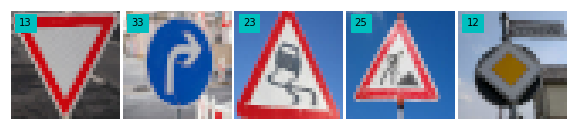

In [22]:
### Load the images and plot them here.
import os

def load_new_image(file_name):
    image = cv2.imread(file_name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image
    
extra_signs = [ load_new_image("./extra/"+name) for name in ["1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg"]]
extra_labels = [ 13 , 33 , 23 , 25 , 12 ]


plt.figure(figsize = (10,2))
gs1 = matplotlib.gridspec.GridSpec(1,5)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

for i in range(5):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.imshow(extra_signs[i])
    plt.text(2,4,str(extra_labels[i]),
         color='k',backgroundcolor='c')
    plt.axis('off')
plt.show()

### Predict the Sign Type for Each Image

In [23]:
### Run the predictions here and use the model to output the prediction for each image.

### pre-process the images with the same pre-processing pipeline used earlier.
X_extra = [ img_preprocess(x) for x in extra_signs ]

# Extra set accuracy and top 5 softmax for each
softmax_operation = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    extra_accuracy = evaluate(X_extra, extra_labels)
    print("Extra Accuracy = {:.3f}".format(extra_accuracy))
    print()
    
    top_5_sm = sess.run(tf.nn.top_k(softmax_operation, k=5), feed_dict={x: X_extra, y: extra_labels, keep_prob: np.array([1.0],dtype=np.float32)})

INFO:tensorflow:Restoring parameters from ./traffic
Extra Accuracy = 1.000



### Analyze Performance

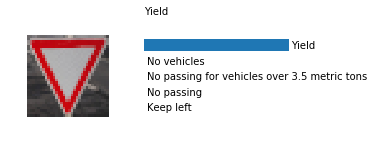

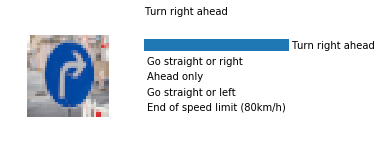

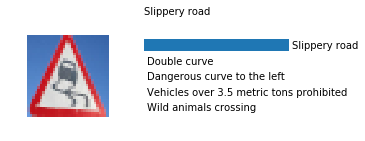

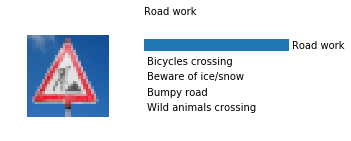

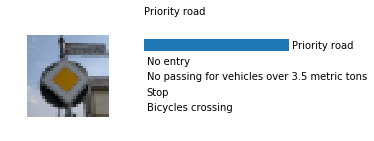

In [36]:
for i in range(5):

    plt.figure(figsize = (5,1.5))
    gs = matplotlib.gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(extra_signs[i])
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(5-np.arange(5),top_5_sm[0][i], align='center')
    for i_label in range(5):
        plt.text(top_5_sm[0][i][i_label]+.02,5-i_label-.25,
            sign_names['SignName'][top_5_sm[1][i][i_label]])
    plt.axis('off');
    plt.text(0,6.95,sign_names['SignName'][extra_labels[i]]);
    plt.show();


### Slippery image

As you can see before augmenting the dataset with extra images the slippery road, for which we have very little training data, was missclassified!

![slippery_missclassified](3_first.jpeg)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [24]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    test = tf.get_default_graph().get_collection(tf_activation)[0]
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        activation = test.eval(session=sess,feed_dict={x : image_input , keep_prob: np.array([1.0],dtype=np.float32)})
        
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range( min(48,featuremaps)):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./traffic


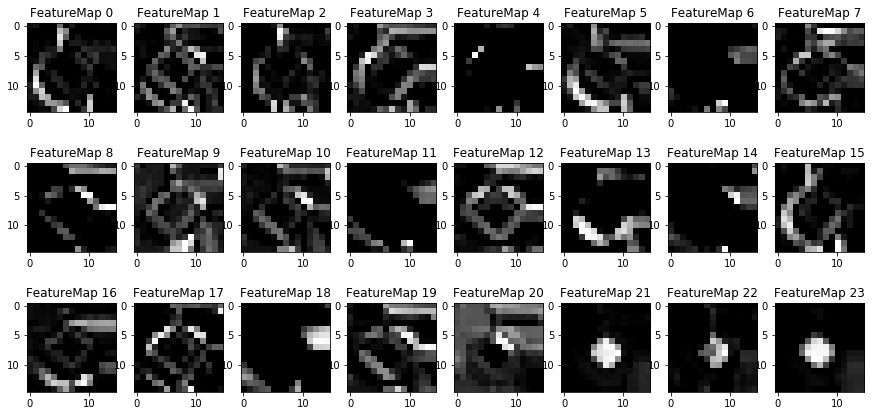

In [39]:
import random
random.shuffle(X_extra)

outputFeatureMap(np.array(X_extra),"L1")

INFO:tensorflow:Restoring parameters from ./traffic


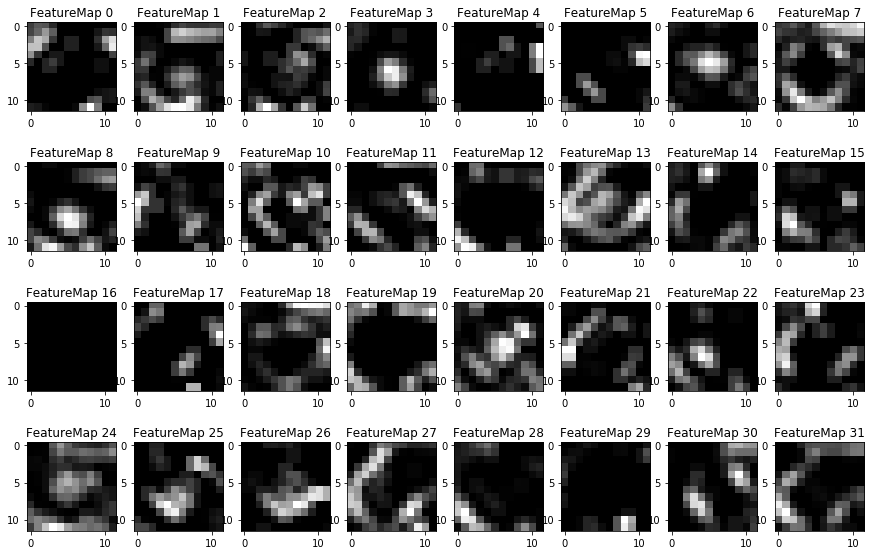

In [40]:
outputFeatureMap(X_extra,"L2")

In [48]:
horse = load_new_image("./extra/no_sign.jpg")
X_extra = []
X_extra.append( img_preprocess(horse) )

INFO:tensorflow:Restoring parameters from ./traffic
TopKV2(values=array([[ 0.67756557,  0.09473666,  0.03449876,  0.03166825,  0.02627288]], dtype=float32), indices=array([[12, 11, 36, 17, 38]], dtype=int32))


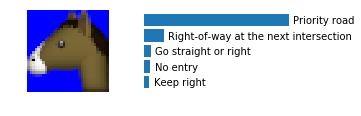

INFO:tensorflow:Restoring parameters from ./traffic


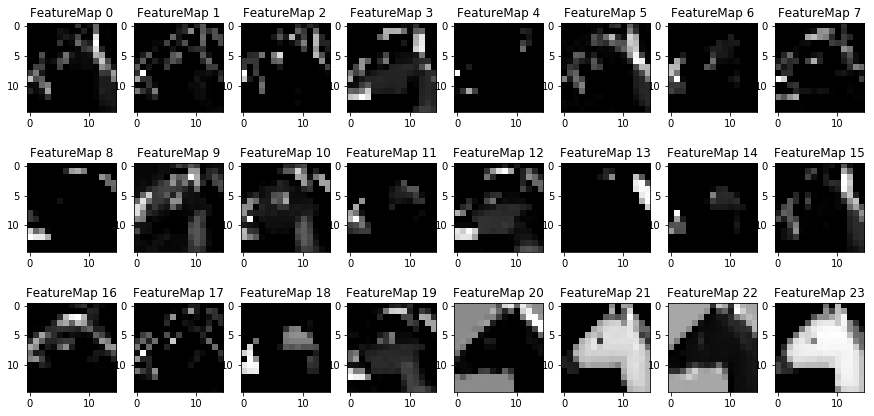

In [51]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_5_sm = sess.run(tf.nn.top_k(softmax_operation, k=5), feed_dict={x: X_extra, y: extra_labels, keep_prob: np.array([1.0],dtype=np.float32)})

print(top_5_sm)    
    
for i in range(1):

    plt.figure(figsize = (5,1.5))
    gs = matplotlib.gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(horse)
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(5-np.arange(5),top_5_sm[0][i], align='center')
    for i_label in range(5):
        plt.text(top_5_sm[0][i][i_label]+.02,5-i_label-.25,
            sign_names['SignName'][top_5_sm[1][i][i_label]])
    plt.axis('off');
    plt.show();

outputFeatureMap(X_extra,"L1")

INFO:tensorflow:Restoring parameters from ./traffic


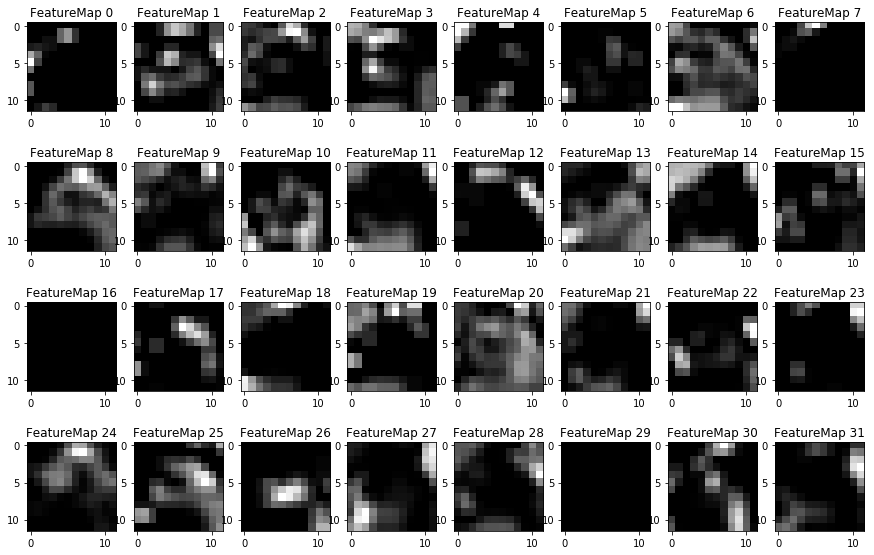

In [52]:
outputFeatureMap(X_extra,"L2")